In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import lagrange
import sklearn
import random
import math
import string
import matplotlib as mpl

from scipy import signal

# 1、导入数据

In [2]:
df_origin = pd.read_csv('D:\\test\\trajectories_0750am_0805am.txt', sep='\s+', header=None,
                 engine='python',
                 names=['veh_id', 'Frame_id', 'Total_Frames', 'Global_Time', 'Local_X', 'Local_Y', 'Global_X',
                        'Global_Y', 'veh_length', 'veh_width', 'veh_class', 'veh_speed', 'veh_Acc', 'Lane_id',
                        'pre_veh_id', 'follow_veh_id', 'Spacing', 'Headway'])

# 单位统一化

In [3]:
df_origin.iloc[:,[4,5,6,7,8,9,11,12,16]] *= 0.3048

In [4]:
# group = df_origin.groupby('veh_id')
# DF = df_origin.copy()
# for g in group:
#     veh_id = g[0]
#     df_group = g[1]
#     b, a = signal.butter(1, 0.2, 'lowpass') 
#     filtedData_v = signal.filtfilt(b, a, df_group['veh_speed'])
#     filtedData_a = signal.filtfilt(b, a, df_group['veh_Acc'])
#     DF.loc[DF['veh_id']==veh_id,'veh_Acc'] = filtedData_a
#     DF.loc[DF['veh_id']==veh_id,'veh_speed'] = filtedData_v

# 轨迹去噪

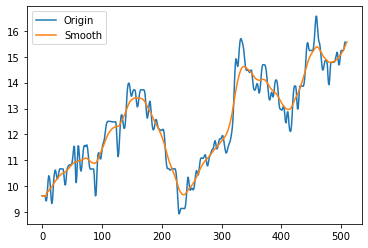

In [5]:
def moving_average(x,y):
    z = 0
    for k in range(-6,6):
        z += y[x+k]
    z = z/12
    return z
def EWMA(v,delta):
    delta_s = 5
    delta_v = 10
    delta_a = 40
    v_sm_list = [v[0]]
    for i in range(1,len(v)-1):
        sum_v = 0
        Z = 0
        D = min(3*delta,i,len(v)-i)
        for k in range(i-D,i+D):
            sum_v += v[k]*math.exp(-abs(i-k)/delta)
            Z += math.exp(-1*abs(i-k)/delta)
        v_sm = sum_v/Z
        v_sm_list.append(v_sm)
    v_sm_list = np.array(v_sm_list)
    return v_sm_list
group = df_origin.groupby('veh_id')
DF = df_origin.copy()
for g in group:
    veh_id = g[0]
    V = g[1].veh_speed.values
    Acc = g[1].veh_Acc.values
    X = g[1].Local_Y.values
    X_sm = X.copy()
    V_sm = V.copy()
    Acc_sm = Acc.copy()
    V_sm0 = EWMA(V,10)
    Acc_sm0 = EWMA(Acc,40)
    X_sm0 = EWMA(X,5)
    X_sm[1:len(g[1])]=X_sm0
    V_sm[1:len(g[1])]=V_sm0
    Acc_sm[1:len(g[1])]=Acc_sm0
    DF.loc[DF['veh_id']==veh_id,'veh_Acc'] = Acc_sm
    DF.loc[DF['veh_id']==veh_id,'veh_speed'] = V_sm
    DF.loc[DF['veh_id']==veh_id,'Local_Y'] = X_sm
plt.plot(V)
plt.plot(V_sm)
plt.legend(['Origin','Smooth'])


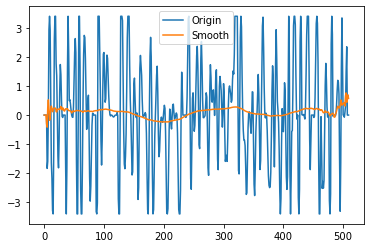

In [6]:
plt.plot(Acc)
plt.plot(Acc_sm)
plt.legend(['Origin','Smooth'])

In [22]:
plt.plot(DF['veh_Acc'].head(500))

KeyError: 'veh_Acc'

In [8]:
df_origin_copy = DF

# 2、生成跟驰对

In [9]:
df_origin_copy.rename(columns={'veh_id': 'pre_veh_id', 'pre_veh_id': 'pre_veh_id1'}, inplace=True)
df = pd.merge(df_origin, df_origin_copy, on=['Frame_id', 'pre_veh_id'], suffixes=['_fol', '_pre'])
df['pre_veh_id'] = df['pre_veh_id'].map(lambda x: str(x))
df['veh_id'] = df['veh_id'].map(lambda x: str(x))
df['pre_fol_id'] = df['pre_veh_id'] + '_' + df['veh_id']

In [10]:
df.drop(columns=['Total_Frames_pre','Total_Frames_fol','Global_Time_fol','Global_Time_pre', 'Global_X_fol',  'Global_X_pre',
                 'Global_Y_fol','Global_Y_pre','veh_width_fol','veh_width_pre','pre_veh_id1',
                 'follow_veh_id_fol','Spacing_pre','Headway_pre','Lane_id_pre','Local_X_fol','Local_X_pre'], inplace=True)

# 3、筛选：小车跟小车

In [11]:
df2 = df[(df['veh_class_pre'] == df['veh_class_fol']) & (df['veh_class_pre'] == 2)]

# 4、输出车辆跟驰时间Times（s）

In [12]:
g1 = df.groupby('pre_fol_id')
CF_start_list = []
CF_end_list = []
CF_id_list = []
for group in g1:
    df_group = group[1]
    Frame_ser = df_group['Frame_id']
    max_t = Frame_ser.max()
    min_t = Frame_ser.min()
    if (max_t - min_t) == len(df_group) - 1:
        CF_start = min_t
        CF_end = max_t
        CF_start_list.append(CF_start)
        CF_end_list.append(CF_end)
        CF_id_list.append(group[0])
    else:
        j = 0
        Frame_ser.sort_values(ascending=False)
        for i in range(1, len(Frame_ser) - 1):
            if Frame_ser[Frame_ser.index[i]] - 1 != Frame_ser[Frame_ser.index[i - 1]]:
                CF_start = Frame_ser[Frame_ser.index[j]]
                CF_end = Frame_ser[Frame_ser.index[i - 1]]
                CF_start_list.append(CF_start)
                CF_end_list.append(CF_end)
                CF_id_list.append(group[0])
                j = i
            elif i == len(Frame_ser) - 1:
                CF_start = Frame_ser[Frame_ser.index[j]]
                CF_end = Frame_ser[Frame_ser.index[i]]
                CF_start_list.append(CF_start)
                CF_end_list.append(CF_end)
                CF_id_list.append(group[0])

In [13]:
CF_dict = {'pre_fol_id': CF_id_list, 'CF_start': CF_start_list, 'CF_end': CF_end_list}
df_time = pd.DataFrame(CF_dict)

# 5、筛选：跟驰时间>60s

In [14]:
df_time['Time(s)'] = (df_time['CF_end'] - df_time['CF_start']) * 0.1
df_time = df_time[df_time['Time(s)'] >= 15]
DF = pd.merge(df2, df_time)
DF = DF[(DF['CF_start'] <= DF['Frame_id']) & (DF['Frame_id'] <= DF['CF_end'])]

In [15]:
DF = DF[DF['Time(s)'] >= 60]

# 6、筛选：车间距小于100米

In [16]:
DF['Spacing_fol'] -= DF['veh_length_pre']
DF = DF[DF['Spacing_fol']<=100]
len(DF.groupby('pre_fol_id'))

371

# 7、筛选：删除匝道和辅助车道的数据

In [17]:
DF = DF[(DF['Lane_id_fol'] != 6)&(DF['Lane_id_fol'] != 7)&(DF['Lane_id_fol'] != 8)]
len(DF.groupby('pre_fol_id'))

371

# 数据导出

In [18]:
DF.to_csv('D://data003.csv')

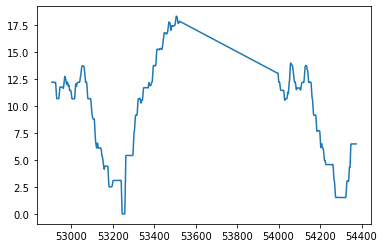

In [19]:
plt.plot(DF['veh_speed_fol'].head(1000))

In [20]:
DF['veh_Acc_fol']

52906     0.000000
52907     0.000000
52908     0.000000
52909     0.000000
52910     0.000000
            ...   
922670   -0.381000
922671    0.762000
922672    1.658112
922673    1.359408
922674    0.448056
Name: veh_Acc_fol, Length: 266581, dtype: float64